### Model Training
- 1.1 Import Data and Required Packages 
- Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [1]:
!pip install joblib
!pip install catboost
!pip install xgboost

  Using cached catboost-1.2-cp310-cp310-win_amd64.whl (101.0 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

Import the CSV Data as Pandas DataFrame

In [7]:
df = pd.read_csv('stud.csv')


Show Top 5 Records

In [8]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Preparing X and Y variables

In [9]:
X = df.drop(columns=['math_score'], axis = 1)

In [10]:
y = df['math_score']

In [11]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in'parental level of education' variable: ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:      ['standard' 'free/reduced']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [13]:
X

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75
...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,99,95
996,male,group C,high school,free/reduced,none,55,55
997,female,group C,high school,free/reduced,completed,71,65
998,female,group D,some college,standard,completed,78,77


In [14]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

Create the Column transformer with the 3 types of transformers

In [17]:
num_features = X.select_dtypes(exclude = "object").columns
cat_features = X.select_dtypes(include = "object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
    ("OneHotEncoder", oh_transformer, cat_features),
    ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [18]:
X = preprocessor.fit_transform(X)

In [22]:
X, X.shape

(array([[ 1.        ,  0.        ,  0.        , ...,  1.        ,
          0.19399858,  0.39149181],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          1.42747598,  1.31326868],
        [ 1.        ,  0.        ,  0.        , ...,  1.        ,
          1.77010859,  1.64247471],
        ...,
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.12547206, -0.20107904],
        [ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.60515772,  0.58901542],
        [ 1.        ,  0.        ,  0.        , ...,  1.        ,
          1.15336989,  1.18158627]]),
 (1000, 19))

In [24]:
# Separate Dataset into train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

Create an Evaluation Function to give all metrics after model training

In [36]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [40]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 5.3402
- Mean Absolute Error: 4.2723
- R2 Score: 0.8735
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.4214
- Mean Absolute Error: 4.2253
- R2 Score: 0.8792


Lasso
Model performance for Training set
- Root Mean Squared Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253


Ridge
Model performance for Training set
- Root Mean Squared Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 5.7077
- Mean Absolute Error: 4.5167
- R2 Score: 0.8555
-----------------------

# Result

In [41]:
pd.DataFrame(list(zip(model_list, r2_list)), columns = ['Model Name', 'R2 Score']).sort_values(by=["R2 Score"], ascending=False)

,Model Name,R2 Score
2,Ridge,0.880593
0,Linear Regression,0.879216
5,Random Forest Regressor,0.853899
7,CatBoosting Regressor,0.851632
8,AdaBoost Regressor,0.850992
1,Lasso,0.825320
6,XGBRegressor,0.821589
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.760231


Linear Regression

In [42]:
lin_model = LinearRegression(fit_intercept = True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is: %.2f"%score)

Accuracy of the model is: 87.92


Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

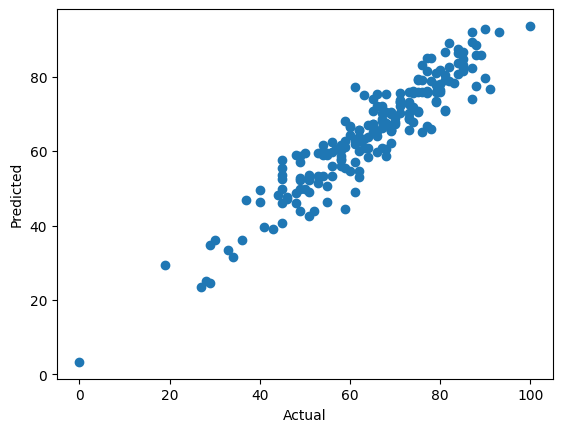

In [43]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<AxesSubplot:xlabel='math_score'>

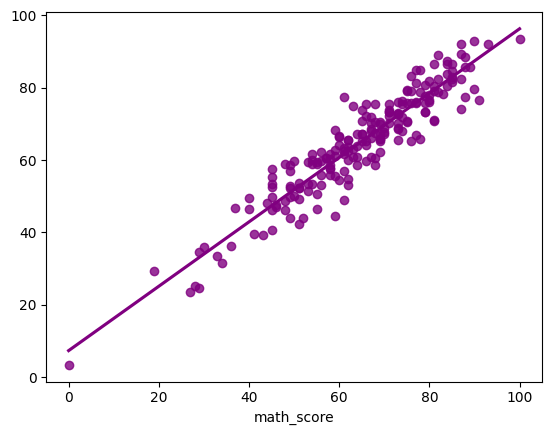

In [46]:
sns.regplot(x=y_test, y=y_pred, ci = None, color='purple')

Difference between actual and predicted values

In [48]:
pred_df = pd.DataFrame({'Actual Value':y_test, 'Predicted Value':y_pred, 'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
521,91,76.6250,14.3750
737,53,59.3750,-6.3750
740,80,76.5000,3.5000
660,74,76.2500,-2.2500
411,84,87.4375,-3.4375
...,...,...,...
408,52,43.8750,8.1250
332,62,62.6250,-0.6250
208,74,67.9375,6.0625
613,65,67.2500,-2.2500
